In [3]:
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-contrib", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/site-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/traitlets/config/application.py", line 1051, in launch_instance
    app = cls.instance(**kwargs)
  File "/usr/local/lib/python3.8/site-packages/traitlets/config/configurable.py", line 575, in instance
    inst = cls(*args, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/jupyter_contrib_core/application.py", line 27, in __init__
    self._refresh_subcommands()
  File "/usr/local/lib/python3.8/site-packages/jupyter_contrib_core/application.py", line 43, in _refresh_subcommands
    get_subcommands_dict = entrypoint.load()
  File "/usr/local/lib/python3.8/site-packages/pkg_resources/__init__.py", line 2450, in load
    return self.resolve()
  File "/usr/local/lib/pyth

In [35]:
import os
import math
import sys
import stat

import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from osgeo import osr
import shapely
from plpygis import Geometry
from shapely.geometry import (
    LineString,
    MultiLineString,
    MultiPoint,
    MultiPolygon,
    Point,
    Polygon,
)

import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils import GridIntersect, Raster
from flopy.utils.gridgen import Gridgen
wd = "./novgorod"
input_directory = os.path.join(wd, "input")

In [36]:
def raster_resample(path, modelgrid):
    rio = Raster.load(path)
    data = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
    return data

In [37]:
srs = osr.SpatialReference()
srs.ImportFromWkt('PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unknown_based_on_Krassovsky_1942_ellipsoid",SPHEROID["Krassovsky_1942",6378245.0,298.3]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",2250000.0],PARAMETER["False_Northing",-5714743.504],PARAMETER["Central_Meridian",44.55],PARAMETER["Scale_Factor",1.0],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]')
proj_string = srs.ExportToProj4()

In [38]:
# Load a polygon shapefile
boundary = gpd.read_file(os.path.join(input_directory, "vectors", "boundary.shp"), crs=proj_string)
boudary_json = boundary.to_json()

/tmp/ipykernel_25/1912189973.py:3: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  boudary_json = boundary.to_json()


In [39]:
nlay = 1
cell_size = 500
buffer = 2000
minx, miny, maxx, maxy = boundary.bounds.minx[0] - buffer, boundary.bounds.miny[0] - buffer, boundary.bounds.maxx[0] + buffer, boundary.bounds.maxy[0] + buffer
n_row = math.ceil((maxx - minx) / cell_size)
n_col = math.ceil((maxy - miny) / cell_size)
delr =  cell_size * np.ones(n_row, dtype=float)
delc =  cell_size * np.ones(n_col, dtype=float)

In [41]:
raster_ws = os.path.join(input_directory, "rasters")
# dem_name = "fabdem.tif"
dem_name = "Relief_new"

rio = Raster.load(os.path.join(raster_ws, dem_name))
arr = rio.get_array(1)
idx = np.isfinite(arr)
vmin, vmax = arr[idx].min(), arr[idx].max()

In [42]:
name = "nn"
exe_name = os.path.join("bin", "mf6")
workspace = os.path.join(wd, "model")
st = os.stat(exe_name)
os.chmod(exe_name, st.st_mode | stat.S_IEXEC)
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=exe_name, version="mf6", sim_ws=workspace
)

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE") #SIMPLE


In [43]:
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=n_col,
    ncol=n_row,
    delr=delr,
    delc=delc,
    top=0,
    botm=-10,
    crs=proj_string,
    xul=minx,
    yul=maxy
)
gridgen_ws = os.path.join(workspace, "grid")
gridgen_exe = os.path.join("bin", "gridgen")
st = os.stat(gridgen_exe)
os.chmod(gridgen_exe, st.st_mode | stat.S_IEXEC)
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws, exe_name=gridgen_exe)
active_domain = Geometry(boundary.geometry.to_wkb()[0]).geojson["coordinates"]
g.add_active_domain([active_domain], [0])

/usr/local/lib/python3.8/site-packages/flopy/mbase.py:96: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


In [44]:
small_riv_gdf = gpd.read_file(os.path.join(input_directory, 'vectors', 'zones_small_river.shp'), crs=proj_string)
refine_level = 3
for river in small_riv_gdf.geometry.to_wkb():
    line = [Geometry(river).geojson["coordinates"]]
    g.add_refinement_features(line, "line", refine_level, [0])


riv_gdf = gpd.read_file(os.path.join(input_directory, 'vectors', 'zones_river.shp'), crs=proj_string)
riv_gdf = riv_gdf.explode()
refine_level = 3
for river in riv_gdf.geometry.to_wkb():
    poly = [Geometry(river).geojson["coordinates"]]
    g.add_refinement_features(poly, "polygon", refine_level, [0])

/tmp/ipykernel_25/3054382126.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  riv_gdf = riv_gdf.explode()


In [45]:
flood = gpd.read_file(os.path.join(input_directory, 'vectors', "flood_zone.shp"), crs=proj_string)
for zone in flood.geometry.to_wkb():
    line = Geometry(zone).geojson["coordinates"]
    g.add_refinement_features(line, "polygon", 2, [0])

In [46]:
g.build(verbose=False)

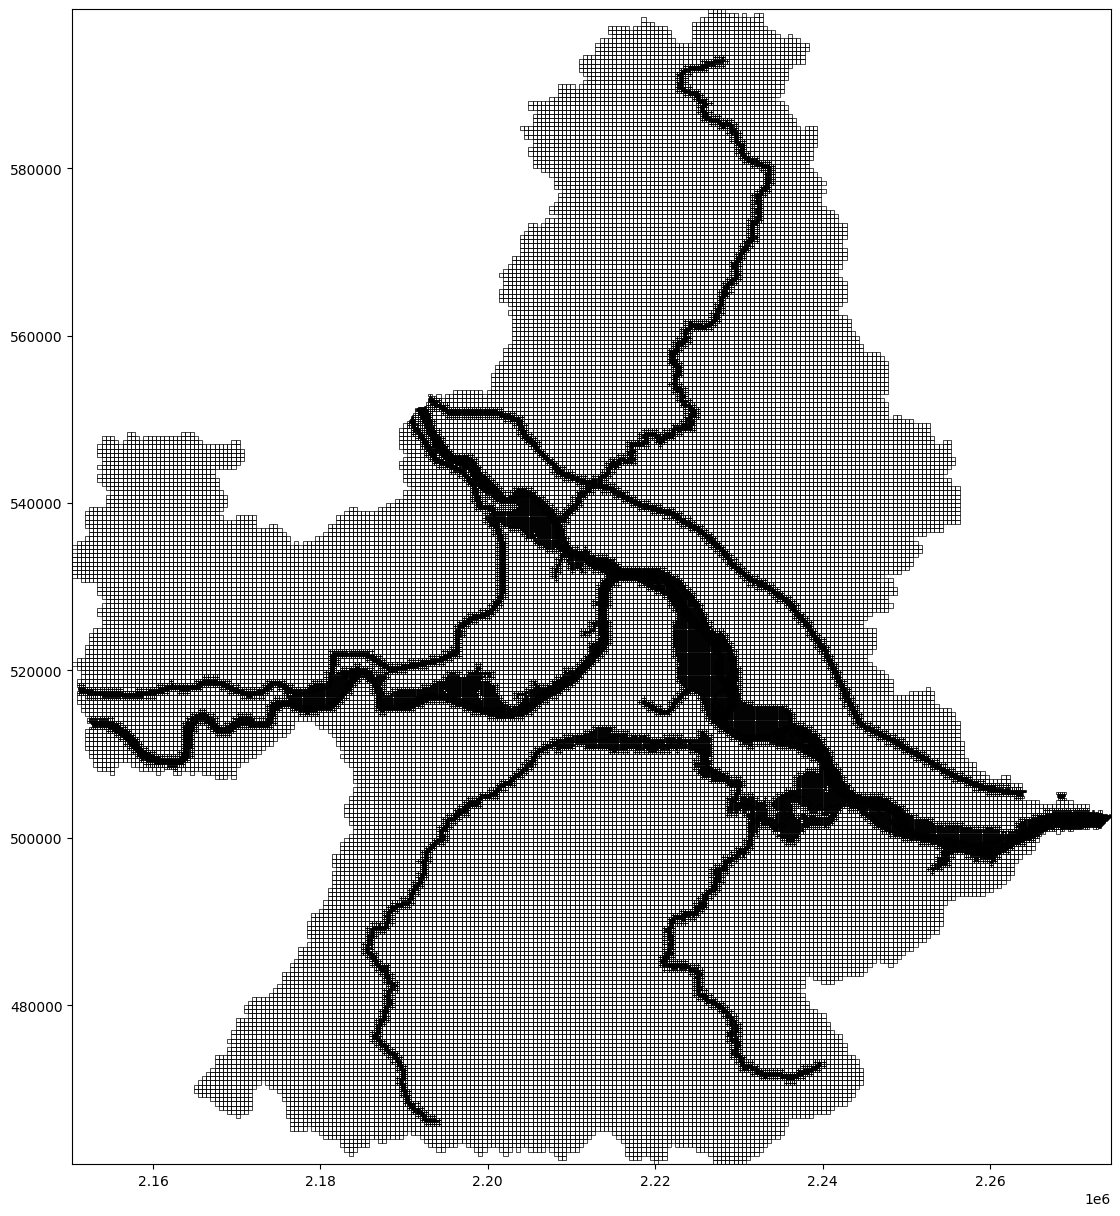

In [15]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
g.plot(ax, linewidth=0.5)

In [47]:
small_river_cells = []
for zn, river in enumerate(small_riv_gdf.geometry.to_wkb()):
    line = [Geometry(river).geojson["coordinates"]]
    cellids = g.intersect(line, 'line', 0)
    small_river_cells.append([cellids, zn])
river_cells = []
for zn, river in enumerate(riv_gdf.geometry.to_wkb()):
    poly = [Geometry(river).geojson["coordinates"]]
    cellids = g.intersect(poly, 'polygon', 0)
    river_cells.append([cellids, zn + 20])

In [48]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops["ncpl"]
top = gridprops["top"]
botm = gridprops["botm"]
nvert = gridprops["nvert"]
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]
disv = flopy.mf6.modflow.mfgwfdisv.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl,
    top=top,
    botm=botm,
    nvert=nvert,
    vertices=vertices,
    cell2d=cell2d,
    xorigin=minx, yorigin=miny, angrot=0
)

In [49]:
modelgrid = gwf.modelgrid
dem_data = rio.resample_to_grid(
    modelgrid, band=rio.bands[0], method="nearest"
)

In [50]:
bot_data = raster_resample(os.path.join(input_directory, "rasters", "bot.tif"), modelgrid)
bot_data = np.where(dem_data - bot_data < 7, dem_data - 7, bot_data)
disv.top = dem_data
disv.botm = bot_data

In [51]:
# IC
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=dem_data)

In [52]:
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=9.36, save_flows=True
)

In [53]:
gen_icpl = []
river_stress_data = []

for river in small_river_cells:
    zn = river[1]
    for data in river[0]:
        icpl = data[0]
        length = data[2]
        if icpl >= 0 and icpl not in gen_icpl:
            gen_icpl.append(icpl)
            stage = disv.top[icpl]
            conductance = 100
            # conductance = 100
            river_stress_data.append([(0, icpl), stage, conductance, stage - 1.5, f"zn_{zn}"])

for river in river_cells:
    zn = river[1]
    for data in river[0]:
        icpl = data[0]
        length = data[2]
        if icpl >= 0 and icpl not in gen_icpl:
            gen_icpl.append(icpl)
            stage = disv.top[icpl]
            conductance = 1000
            # conductance = 2500
            river_stress_data.append([(0, icpl), stage, conductance, stage - 5, f"zn_{zn}"])
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data=river_stress_data, save_flows=True, boundnames=True)

In [54]:
rch_spd = {0: 0.0002225}
rch = flopy.mf6.ModflowGwfrcha(
    gwf, readasarrays=True, pname="rch", print_input=True, recharge=rch_spd
)

In [55]:
drn_std = [ [(0, cell[0]), top, 10000] for cell, top in zip(disv.cell2d.array, disv.top.array)]

In [56]:
drn = flopy.mf6.ModflowGwfdrn(
    gwf, print_input=True, print_flows=True, stress_period_data=drn_std
)

In [57]:
# OBS
obsdict = {}
obslist = []
wells_wtd = pd.read_csv(os.path.join(input_directory, "vectors", "well_regime_sort2.csv"))
for index, well in wells_wtd.iterrows():
    wells_geom = [[float(well.X), float(well.Y)]]
    node = g.intersect(wells_geom, "point", 0)
    obslist.append((f"h_{well.id1}", "HEAD", (0, node[0][0])))
    
obsdict["{}.obs.head.csv".format(name)] = obslist
obs = flopy.mf6.ModflowUtlobs(
    gwf, print_input=True, continuous=obsdict
)

In [58]:
# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord=f"{name}.cbb",
    head_filerecord=f"{name}.hds",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)


In [59]:
# Write the datasets
sim.set_all_data_external(True)
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model nn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 55839 based on size of stress_period_data
    writing package rch...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 129782 based on size of stress_period_data
    writing package obs_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler

<a list of 17 text.Text objects>

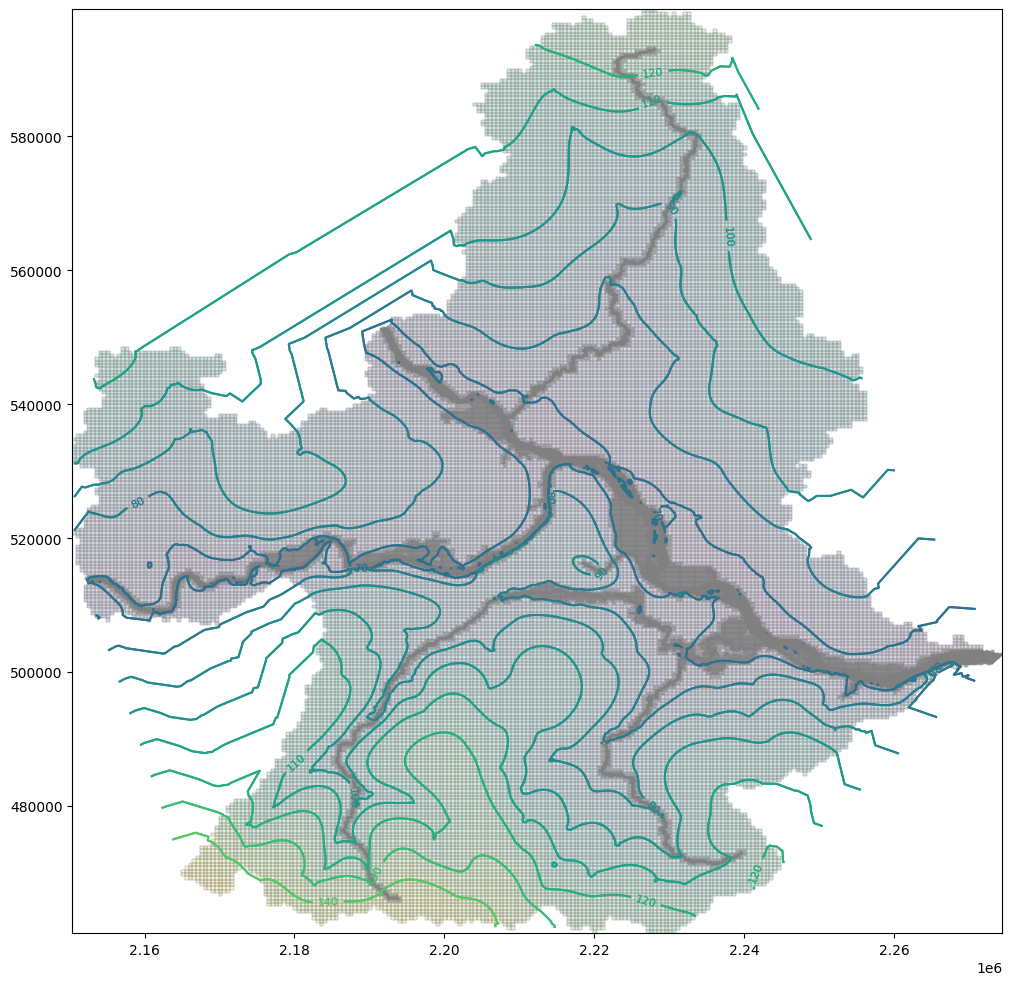

In [33]:
headfile = f"{name}.hds"
fname = os.path.join(workspace, headfile)
hds = flopy.utils.HeadFile(fname)
head = hds.get_data()
levels = np.arange(0, 200, 10)
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_array(head, alpha=0.2)
pmv.plot_grid(alpha=0.2)
contour = pmv.contour_array(head, levels=levels)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
contour = pmv.contour_array(head, levels=levels)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

In [77]:
boundary = gpd.read_file('novgorod/input/vectors/boundary.shp', crs=proj_string)
CRS = boundary.crs
bounds = boundary.bounds
range_x = bounds.maxx[0] - bounds.minx[0]
range_y = bounds.maxy[0] - bounds.miny[0]
num_cells_x = int(range_x / 500)
num_cells_y = int(range_y / 500)

cell2d = m.disv.cell2d.get_data()
centroids_x = [cell[1] for cell in cell2d]
centroids_y = [cell[2] for cell in cell2d]

# Define grid_x and grid_y
gridx, gridy = np.meshgrid(np.linspace(bounds.minx[0], bounds.maxx[0], num=num_cells_x),
                           np.linspace(bounds.miny[0], bounds.maxy[0], num=num_cells_y))
transform = from_origin(gridx.min(), gridy.max(), 500, 500)
# Original coordinates
original_coords = np.array([centroids_x, centroids_y]).T  # x_coordinates and y_coordinates should be 1D arrays containing the x and y coordinates of your original data points respectively.

# Interpolate data
interpolated_data = griddata(original_coords, head.flatten(), (gridx, gridy), method='linear')  # 'nearest', 'linear', or 'cubic' interpolation methods can be used depending on the data.

# Now use interpolated_data with rasterio
new_dataset = rasterio.open(
    "head_drn.tif",
    'w',
    driver='GTiff',
    height=interpolated_data.shape[0],
    width=interpolated_data.shape[1],
    count=1,
    dtype=str(interpolated_data.dtype),
    nodata=np.nan,
    crs=CRS,
    transform=transform,
)
new_dataset.write(interpolated_data[::-1], 1)
new_dataset.close()

In [60]:
obs_prp = wells_wtd
# obs_prp = pd.read_csv("./sources/well_regime.csv", delimiter=';')
obs_prp["well"] = "H_" + obs_prp["id1"].astype(str)
obs_prp["time"] = 1.0
table_obs = pd.pivot_table(obs_prp, values='elevation', index='time',
                       columns=['well'], aggfunc=np.min)
table_obs = table_obs.reset_index()
table_obs.to_csv(os.path.join(workspace, f"{name}.obs.head.csv"), index=False)

In [95]:
zone_kf_gdf = gpd.read_file(os.path.join(input_directory, "vectors", "zone_kf.shp"), crs=proj_string)
zone_kf_gdf.head()
zones_kf = []
df = pd.DataFrame(columns=["icpl", "zone"])
for zn, zn_kf in enumerate(zone_kf_gdf.geometry.to_wkb()):
    poly = [Geometry(zn_kf).geojson["coordinates"]]
    cellids = g.intersect(poly, 'polygon', 0)
    df_temp = pd.DataFrame()
    df_temp["icpl"] = cellids["nodenumber"]
    df_temp["zone"] = zn + 1
    df = pd.concat([df, df_temp])
df_fin = df.drop_duplicates(subset=["icpl"], keep="first")
df_fin.to_csv(os.path.join(input_directory, "vectors", "zones_kf.csv"), index=False)

In [96]:
df_fin = pd.read_csv(os.path.join(input_directory, "vectors", "zones_kf.csv"))
zone_kf = df_fin.sort_values(by=["icpl"])["zone"].to_numpy()

In [97]:
import pp_alg
polygon = boundary.geometry.values[0]
points = pd.read_csv(os.path.join(input_directory, "vectors", "well_regime_sort2.csv"))
existing_points = [(x, y) for x, y in zip(points.X, points.Y)]
# Example usage
new_points = np.array(pp_alg.generate_points_within_polygon(polygon, existing_points, grid_spacing=10000, min_distance=2500))
new_points = [Point(x, y) for x, y in zip(new_points[:, 0], new_points[:, 1])]
# points = [Point(x, y) for x, y in zip(xv.ravel(), yv.ravel())]
points_gdf = gpd.GeoDataFrame(new_points, columns=['geometry'])

# Only keep points that fall within the polygon
points_in_polygon = points_gdf[points_gdf.geometry.apply(lambda point: boundary.geometry.contains(point).any())]

# Set the CRS of the points geodataframe to match the boundary's
points_in_polygon.crs = boundary.crs
points_in_polygon["name"] = points_in_polygon.reset_index().index + 1
points_in_polygon["name"] = 'pp_' + points_in_polygon["name"].astype(str)
for index, pp in points_in_polygon.iterrows():
    point = [Geometry(points_in_polygon.geometry.to_wkb()[index]).geojson["coordinates"]]
    node = g.intersect(point, "point", 0)
    points_in_polygon.loc[index, "zone"] = zone_kf[node[0][0]] + 1
points_in_polygon.to_file(os.path.join(input_directory, "vectors", 'pp.shp'))

/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [5]:
exe_name = os.path.join("bin", "mf6")
st = os.stat(exe_name)
os.chmod(exe_name, st.st_mode | stat.S_IEXEC)

In [30]:
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
ws = './novgorod/model_old_pest'
model_name = 'nn'

sim = flopy.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model(model_name)
modelgrid = m.modelgrid

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package oc...
    loading package obs...
    loading package riv...
    loading package npf...
    loading package ic...
    loading package rch...
  loading solution package nn...


In [31]:
tdis = sim.get_package("tdis")
tdis.perioddata = [(1, 1, 1.0), (30, 6, 1.0)]
tdis.nper = 2

In [32]:
# storage package
sy = flopy.mf6.ModflowGwfsto.sy.empty(m, layered=True)
sy["data"] = 0.2

ss = flopy.mf6.ModflowGwfsto.ss.empty(
    m, layered=True, default_value=0.00009
)

sto = flopy.mf6.ModflowGwfsto(
    m,
    pname="sto",
    save_flows=True,
    iconvert=1,
    ss=ss,
    sy=sy,
    steady_state={0: True},
    transient={1: True},
)

In [33]:
# riv_pd = pd.read_csv(os.path.join(ws, "nn.riv_stress_period_data_1.txt"), header=None, sep='\s+')
# std_riv = [[(node[0] - 1, node[1] - 1), node[2], node[3]*1000000, node[4], node[5]] for node in riv_pd.values]
# riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(m, stress_period_data={0: std_riv, 1: [()]}, 
#                                                save_flows=True, boundnames=True)
riv = m.get_package("RIV")
riv.stress_period_data = {0: riv.stress_period_data.array[0], 1: [()]}
print(riv.stress_period_data.array[0]['cond'])

[ 19.66560902  18.73907748  19.67521239 ...  16.8371     428.96144558
  91.51075   ]


In [36]:
riv_pd = pd.read_csv(os.path.join(ws, "nn.chd_stress_period_data_1.txt"), header=None, sep='\s+')
std_riv = [[(int(node[0] - 1), int(node[1] - 1)), node[2]] for node in riv_pd.values]
chd = flopy.mf6.ModflowGwfchd(m, stress_period_data={0:[()], 1: std_riv})

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_10245/2122052269.py:1: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_10245/2122052269.py:1: DeprecationWarning: invalid escape sequence \s


EmptyDataError: No columns to parse from file

In [38]:
# Write the datasets
sim.exe_name = exe_name
sim.set_all_data_external(True)
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package nn...
  writing model nn...
    writing model name file...
    writing package disv...
    writing package oc...
    writing package obs_0...
    writing package riv_0...
    writing package npf...
    writing package ic...
    writing package rch...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 79669 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                

<a list of 1053 text.Text objects>

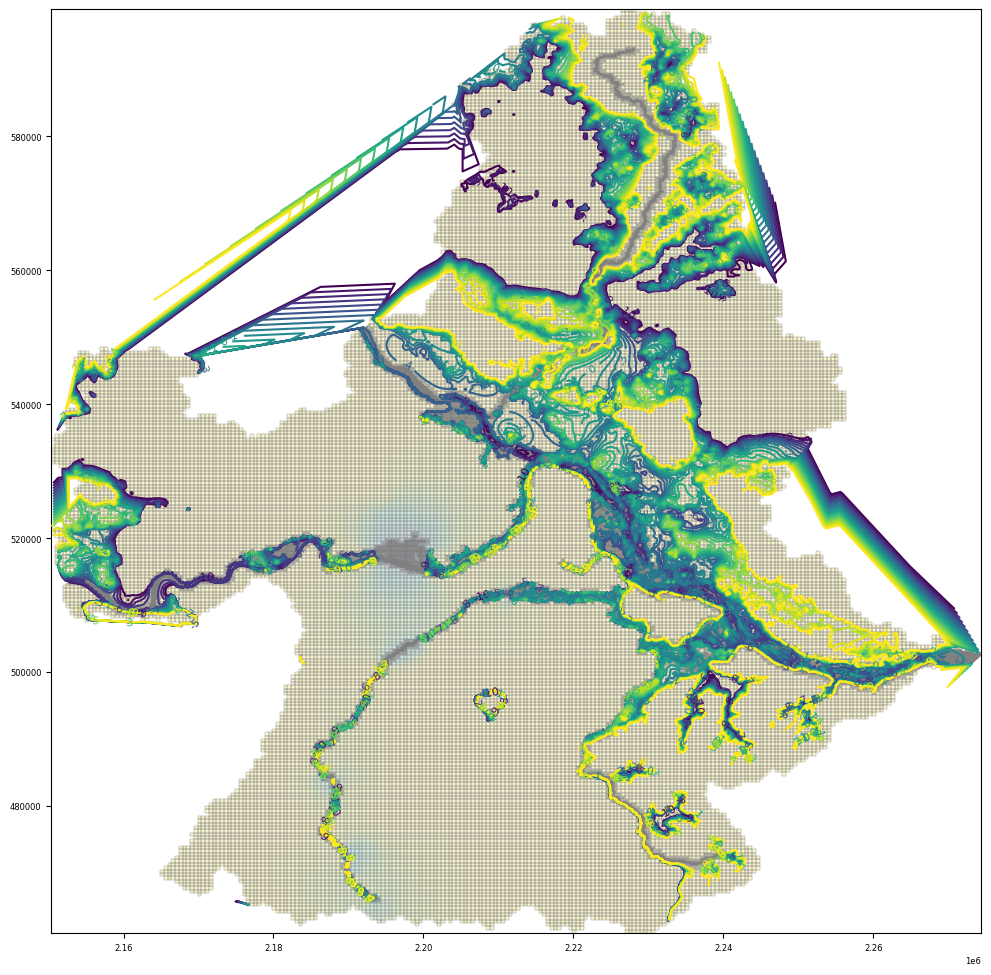

In [44]:
headfile = f"{model_name}.hds"
fname = os.path.join(ws, headfile)
hds = flopy.utils.HeadFile(fname)
head = hds.get_data(kstpkper=(5, 1))
head_st = hds.get_data(kstpkper=(0, 0))
head_dif = head - head_st
head_change = modelgrid.top - head
levels = np.arange(-10, 10, 1)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_array(head_change, alpha=0.2)
pmv.plot_grid(alpha=0.2)
contour = pmv.contour_array(head_change, levels=levels)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

In [42]:
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

boundary = gpd.read_file('novgorod/input/vectors/boundary.shp', crs=proj_string)
CRS = boundary.crs
bounds = boundary.bounds
head_change_rast = np.where(head_change <= 0.1, 0.1, head_change)
head_change_rast = np.where((head_change_rast > 0.1) & (head_change_rast<=0.7), 0.7, head_change_rast)
head_change_rast = np.where((head_change_rast > 0.7) & (head_change_rast<=1.2), 1.2, head_change_rast)
head_change_rast = np.where((head_change_rast > 1.2) & (head_change_rast<=2), 2, head_change_rast)
head_change_rast = np.where((head_change_rast > 2) & (head_change_rast<=3.2), 3.2, head_change_rast)
head_change_rast = np.where(head_change_rast > 3.2, 4, head_change_rast)
print(np.unique(head_change_rast))
range_x = bounds.maxx[0] - bounds.minx[0]
range_y = bounds.maxy[0] - bounds.miny[0]

# Calculate the number of cells for a grid cell size of 50m
num_cells_x = int(range_x / 50) 
num_cells_y = int(range_y / 50)

cell2d = m.disv.cell2d.get_data()
centroids_x = [cell[1] for cell in cell2d]
centroids_y = [cell[2] for cell in cell2d]

# Define grid_x and grid_y
gridx, gridy = np.meshgrid(np.linspace(bounds.minx[0], bounds.maxx[0], num=num_cells_x),
                           np.linspace(bounds.miny[0], bounds.maxy[0], num=num_cells_y))
transform = from_origin(gridx.min(), gridy.max(), 50, 50)
# Original coordinates
original_coords = np.array([centroids_x, centroids_y]).T  # x_coordinates and y_coordinates should be 1D arrays containing the x and y coordinates of your original data points respectively.

# Interpolate data
interpolated_data = griddata(original_coords, head_change_rast.flatten(), (gridx, gridy), method='linear')  # 'nearest', 'linear', or 'cubic' interpolation methods can be used depending on the data.

# Now use interpolated_data with rasterio
new_dataset = rasterio.open(
    "flood_zones.tif",
    'w',
    driver='GTiff',
    height=interpolated_data.shape[0],
    width=interpolated_data.shape[1],
    count=1,
    dtype=str(interpolated_data.dtype),
    nodata=np.nan,
    crs=CRS,
    transform=transform,
)
new_dataset.write(interpolated_data[::-1], 1)
new_dataset.close()

[0.1 0.7 1.2 2.  3.2 4. ]


In [2]:
import pyemu
import os
pst = pyemu.Pst(os.path.join('novgorod', 'master_glm_2', 'nn_pp.pst'))
pst.parrep(os.path.join('novgorod', 'master_glm_2', 'nn_pp.par'))
pst.control_data.noptmax = 0
pst.write(os.path.join(os.path.join('novgorod', 'master_glm_2'), 'nn_pp1.pst'))
pyemu.os_utils.run("pestpp-glm nn_pp1.pst", cwd=os.path.join('novgorod', 'master_glm_2'))

Updating parameter values from novgorod/master_glm_2/nn_pp.par
parrep: updating noptmax to 0
noptmax:0, npar_adj:350, nnz_obs:199


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.5
binary compiled on Jun 29 2023 at 04:49:25

started at 10/13/23 13:05:52
...processing command line: ' ./pestpp-glm nn_pp1.pst'
...using serial run manager

using control file: "nn_pp1.pst"

in directory: "/app/novgorod/master_glm_2"
on host: "504ae47f4c4c"

processing control file nn_pp1.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1
parameter warning: 78 parameters are at lower bound
parameter warning: 160 parameters are at upper bound
checking model IO files...done
              starting serial run manager ...






    ---  starting serial run manager 